In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Example of how regression estimates can differ from the truth

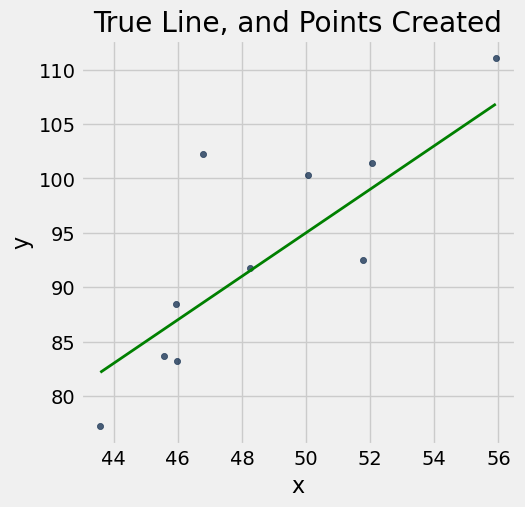

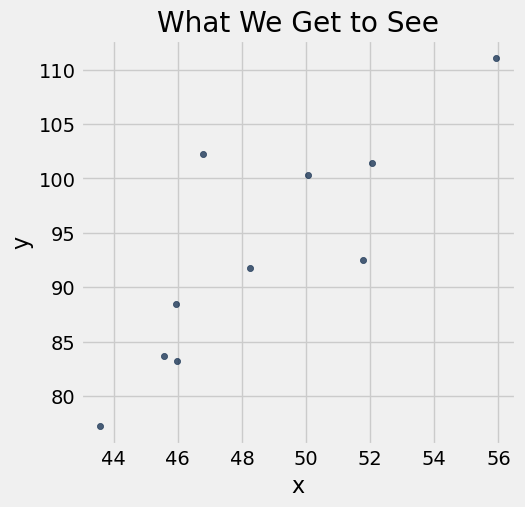

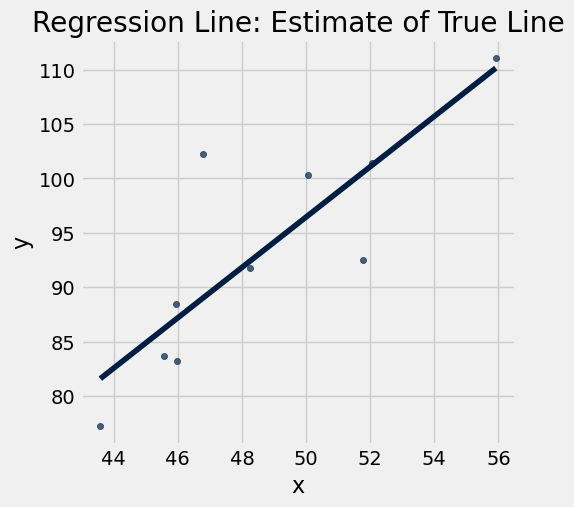

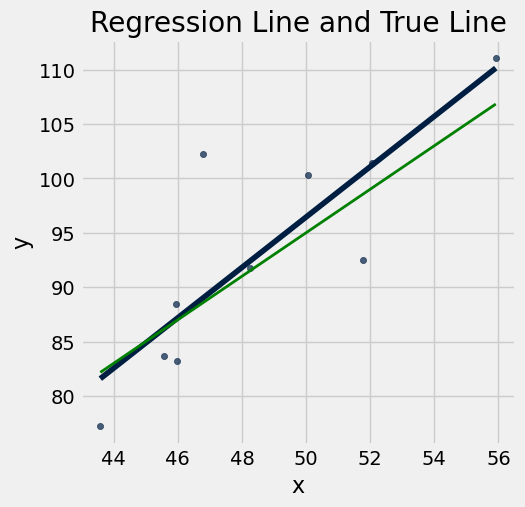

In [2]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plt.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plt.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title("Regression Line and True Line")

draw_and_compare(true_slope=2, true_int=-5, sample_size=10)

# Regression Prediction

In [3]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    """Return an array of all the residuals"""
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

In [4]:
births = Table.read_table('data/baby.csv')
births.sample(3).show()

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
132,273,28,62,113,False
126,285,24,64,140,False
110,277,36,61,116,False


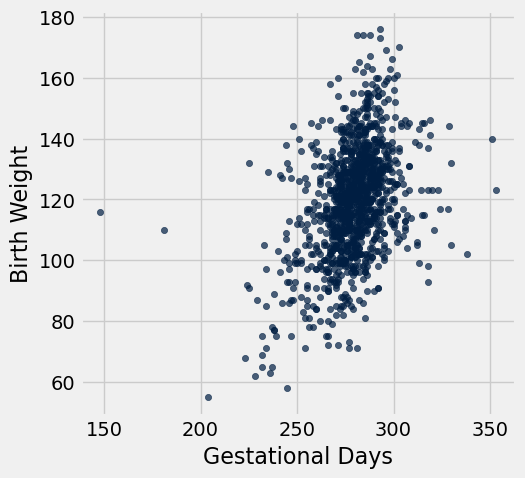

In [5]:
births.scatter('Gestational Days', 'Birth Weight')

In [6]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.40754279338885108

In [7]:
# Preterm and postterm pregnancy cutoffs, according to the CDC
37 * 7, 42 * 7

(259, 294)

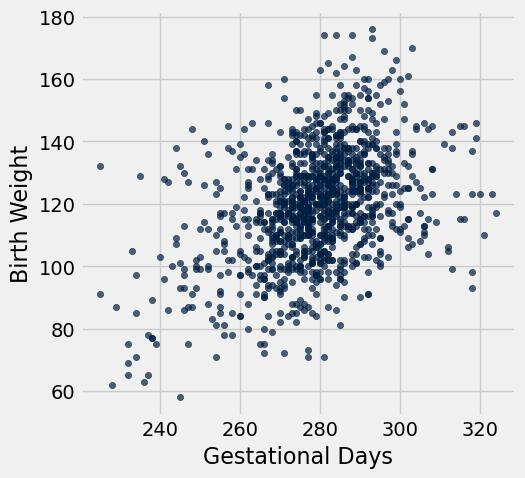

In [8]:
births = births.where('Gestational Days', are.between(225, 325))
births.scatter('Gestational Days', 'Birth Weight')

In [9]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.42295118452423991

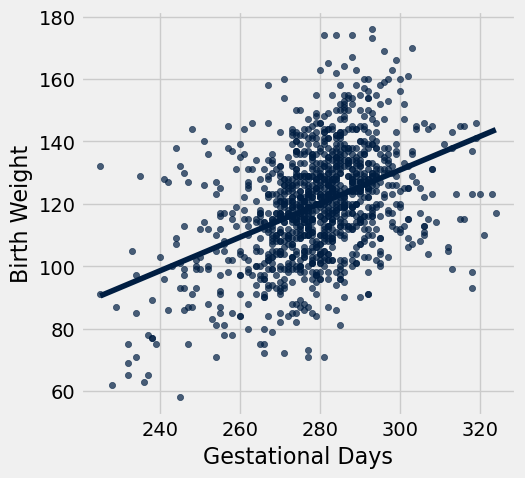

In [10]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [11]:
# Goal: can we estimate the *true* relationship between x and y?

In [12]:
slope(births, 'Gestational Days', 'Birth Weight')

0.53784536766790358

In [13]:
# Future Lawton: do this without a function, and then turn it into a function
def bootstrap_slope_interval(t, x, y, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the slope of the true line, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results (you don't have to understand this code)
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', round(observed_slope, 3))
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(round(left, 3), 'to', round(right, 3))

Slope of regression line: 0.538
Approximate 95%-confidence interval for the slope of the true line:
0.459 to 0.618


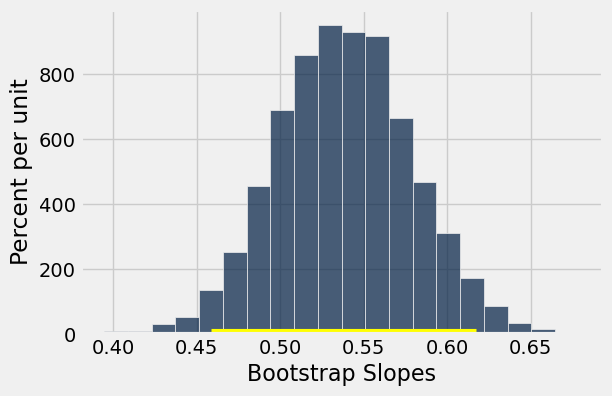

In [14]:
bootstrap_slope_interval(births, 'Gestational Days', 'Birth Weight')

In [15]:
# predicting a confidence interval for someone who's not in our sample
# we have data for 300 gestational days, but it's all over the place and only for people in the sample
# let's do a bootstrap to see how the prediction changes

In [16]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [17]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.80951674248769

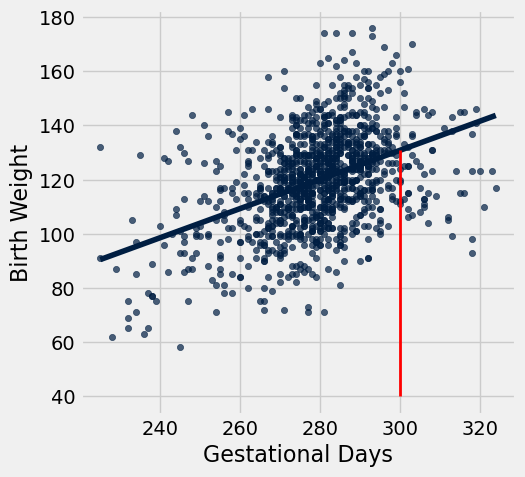

In [18]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plt.plot([x, x], [40, prediction_at_300], color='red', lw=2);

## Different bootstrap samples will give different estimates

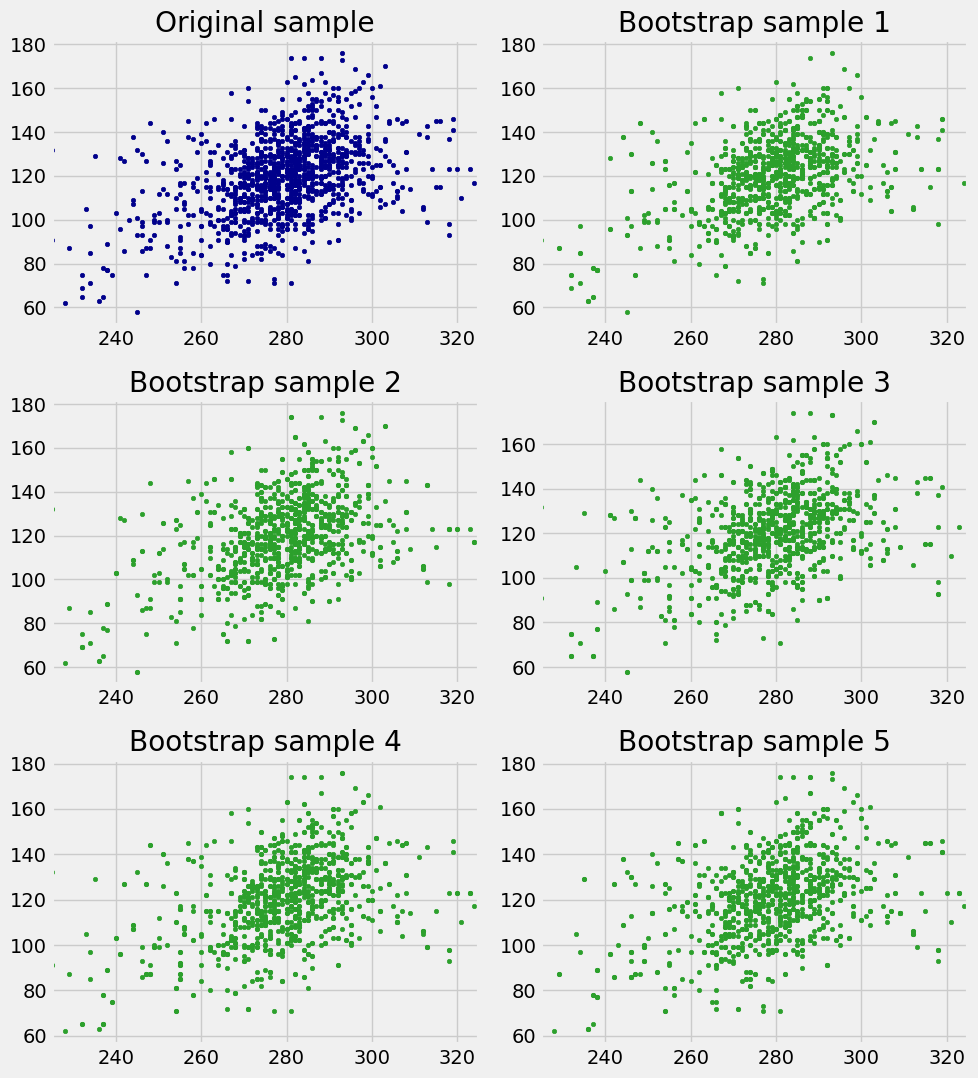

In [19]:
# 5 bootstrap samples
plt.figure(figsize=(10, 11))
plt.subplot(3, 2, 1)
plt.scatter(births[1], births[0], s=10, color='darkblue')
plt.xlim([225, 325])
plt.title('Original sample')

for i in np.arange(1, 6, 1):
    plt.subplot(3,2,i+1)
    resampled = births.sample()
    plt.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plt.xlim([225, 325])
    plt.title('Bootstrap sample '+str(i))
plt.tight_layout()

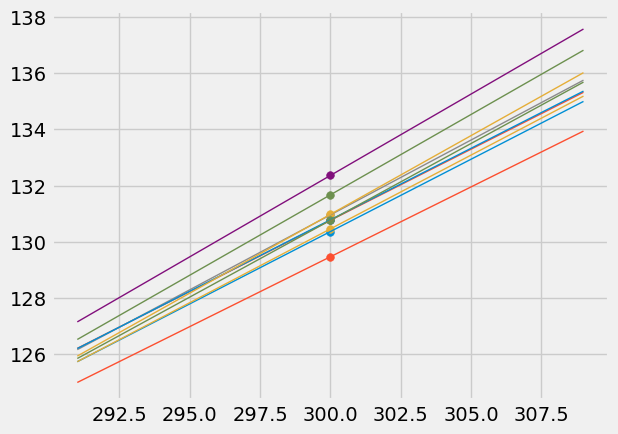

In [20]:
# 10 bootstrap predictions
x = 300

lines = Table(['slope','intercept'])
for i in range(10):
    rep = births.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

lines['prediction at x='+str(x)] = lines.column('slope')*x + lines.column('intercept')

xlims = np.array([291, 309])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x = x*lines['slope'] + lines['intercept']

for i in range(10):
    plt.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plt.scatter(x, fit_x[i], s=30)

In [21]:
lines

slope,intercept,prediction at x=300
0.514326,-23.9335,130.364
0.50597,-21.0272,130.764
0.52478,-26.9749,130.459
0.571532,-39.7896,131.67
0.532471,-28.7848,130.957
0.578703,-41.2509,132.36
0.508587,-21.7946,130.782
0.49673,-19.5513,129.468
0.559988,-37.0205,130.976
0.546116,-33.0701,130.765


In [22]:
# Bootstrap prediction of variable y at new_x
# Data contained in table; prediction by regression of y based on x
# repetitions = number of bootstrap replications of the original scatter plot
def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    #   Bootstrap the scatter; 
    #   get the regression prediction at new_x; 
    #   add to the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = prediction_at(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = prediction_at(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plt.xlabel('predictions at x='+str(new_x))
    plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

Height of regression line at x=300: 130.809516742
Approximate 95%-confidence interval:
128.966965951 132.785261005


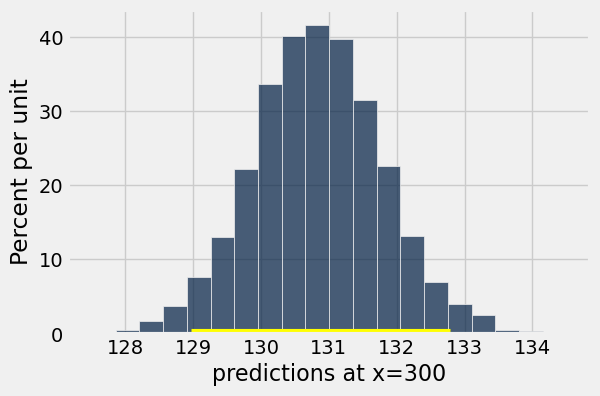

In [23]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300, 5000)

Height of regression line at x=285: 122.741836227
Approximate 95%-confidence interval:
121.732649527 123.79827408


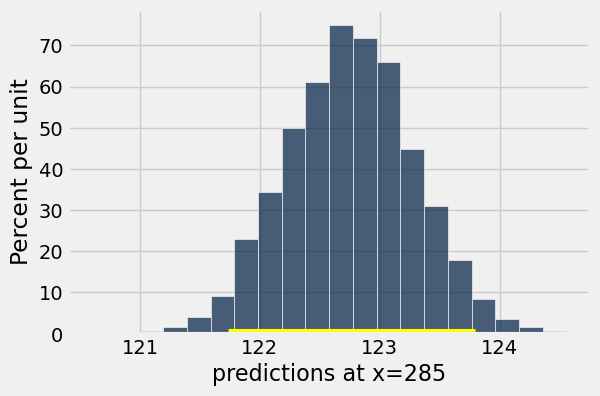

In [24]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 285, 5000)

In [25]:
np.mean(births.column('Gestational Days'))

279.11015490533561

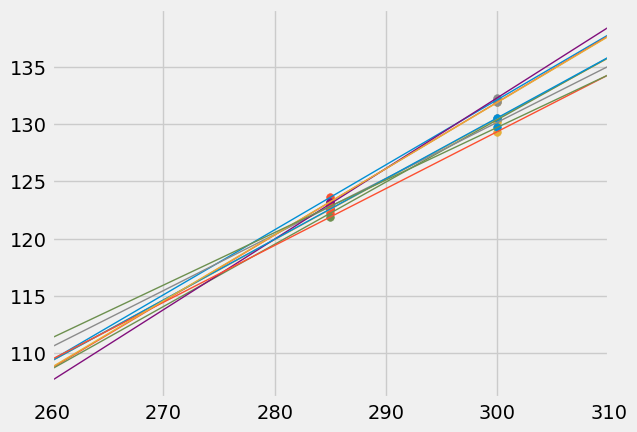

In [26]:
# predictions closer to the mean have less spread than predictions farther from the mean
x1 = 300
x2 = 285

lines = Table(['slope','intercept'])
for i in range(10):
    rep = births.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

xlims = np.array([260, 310])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x1 = x1*lines['slope'] + lines['intercept']
fit_x2 = x2*lines['slope'] + lines['intercept']

plt.xlim(xlims)
for i in range(10):
    plt.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plt.scatter(x1, fit_x1[i], s=30)
    plt.scatter(x2, fit_x2[i], s=30)

# What if the line is flat and there's no association at all??

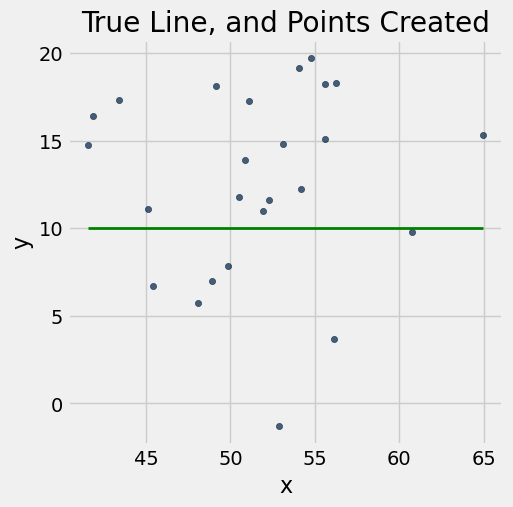

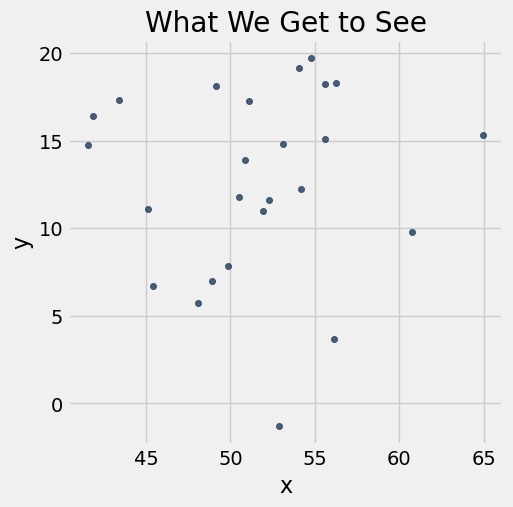

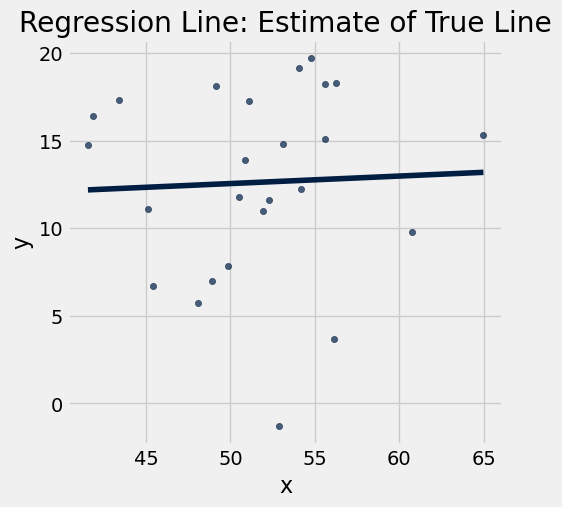

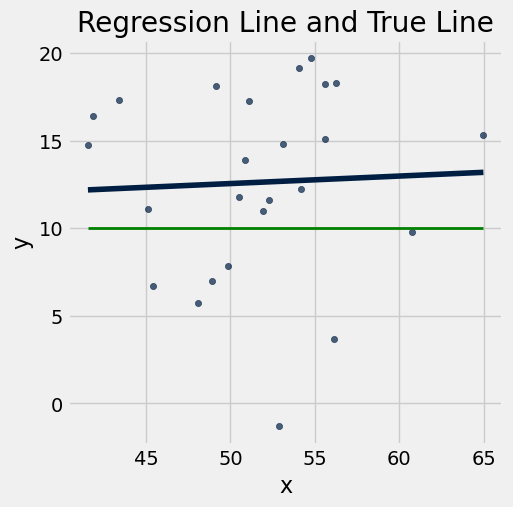

In [27]:
draw_and_compare(true_slope=0, true_int=10, sample_size=25)

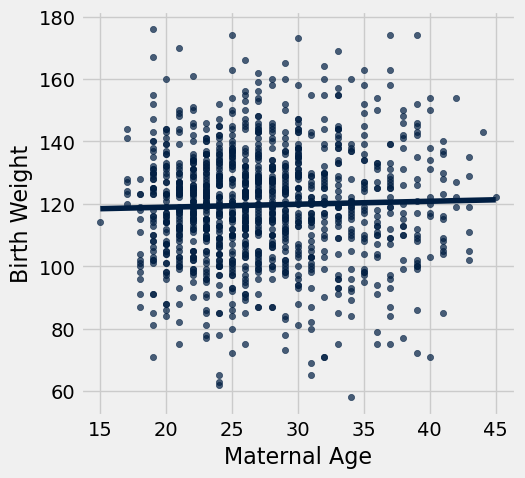

In [28]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

In [29]:
slope(births, 'Maternal Age', 'Birth Weight')

0.095142237298344659

Slope of regression line: 0.095
Approximate 95%-confidence interval for the slope of the true line:
-0.092 to 0.282


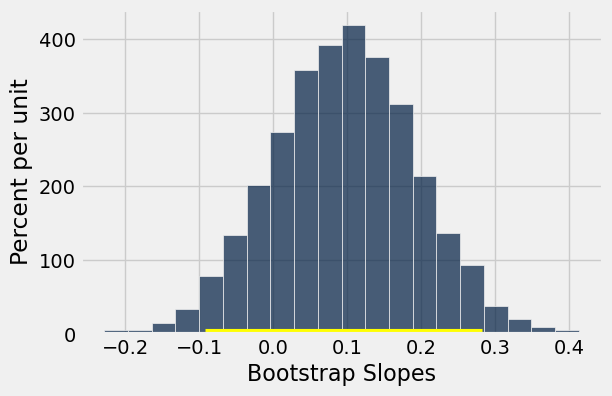

In [30]:
bootstrap_slope_interval(births, 'Maternal Age', 'Birth Weight')